In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'data_variables_objetivo.csv'
filename_val = 'data_variables_objetivo_2025.csv'

# Importar el CSV y usar 'date_index' como índice
df = pd.read_csv(filename, index_col='date_index', parse_dates=True)
df_val = pd.read_csv(filename_val, index_col='date_index', parse_dates=True)
# Mostrar el DataFrame
df_copy = df.copy()

C:\Users\Cris2\AppData\Local\Temp\ipykernel_18608\1805224714.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename, index_col='date_index', parse_dates=True)
C:\Users\Cris2\AppData\Local\Temp\ipykernel_18608\1805224714.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_val = pd.read_csv(filename_val, index_col='date_index', parse_dates=True)


In [3]:
df = df.reset_index()  # Si 'date_index' es índice, pásalo a columna
df [['fecha', 'turno']] = df['date_index'].str.split('_', expand=True)

In [5]:
df['fecha'] = pd.to_datetime(df['fecha'])

In [7]:
turno_horas = {
    '1': '00:00:00',
    '2': '12:00:00',
}

df['datetime_turno'] = df.apply(lambda row: pd.to_datetime(f"{row['fecha'].date()} {turno_horas[row['turno']]}"), axis=1)

# Asegurarse de que 'datetime_turno' no esté como columna y como índice a la vez
df = df.sort_values('datetime_turno').set_index('datetime_turno')
df = df.drop(columns=['datetime_turno'], errors='ignore')  # <- eliminar si quedó como columna

# Eliminar filas totalmente vacías
df = df.dropna(how='all')

# Asegurar que el índice es tipo datetime y tiene frecuencia
df.index = pd.DatetimeIndex(df.index)
df.index.freq = pd.infer_freq(df.index)

In [9]:
y = df['au_recuperacion']

In [11]:
y

datetime_turno
2024-01-02 00:00:00    62.742370
2024-01-02 12:00:00    63.721450
2024-01-03 00:00:00    68.335607
2024-01-03 12:00:00    67.360786
2024-01-04 00:00:00    70.736983
                         ...    
2025-03-29 12:00:00    75.920493
2025-03-30 00:00:00    83.961391
2025-03-30 12:00:00    82.811343
2025-03-31 00:00:00    87.899513
2025-03-31 12:00:00    85.596907
Name: au_recuperacion, Length: 832, dtype: float64

In [13]:
zero_counts = (y == 0).sum()
zero_counts

0

In [15]:
missing_values = y.isnull().sum()
missing_values

0

In [17]:
columna = 'au_recuperacion'
df_prop = df_copy[[columna]]

In [19]:
# Resetear el índice y renombrar
df_prop = df_prop.reset_index().rename(columns={'index': 'date_index'})

# Convertir índice a string y separarlo en fecha y turno
df_prop[['fecha', 'turno']] = df_prop['date_index'].astype(str).str.split('_', expand=True)

# Mapear el turno a hora
df_prop['hora_turno'] = df_prop['turno'].map({'1': '08:00:00', '2': '20:00:00'})

# Construir columna ds para Prophet
df_prop['ds'] = pd.to_datetime(df_prop['fecha'] + ' ' + df_prop['hora_turno'])

# Asignar la variable objetivo a y
df_prop['y'] = df_prop[columna]

# Dejar solo lo necesario para Prophet
df_prophet = df_prop[['ds', 'y']]

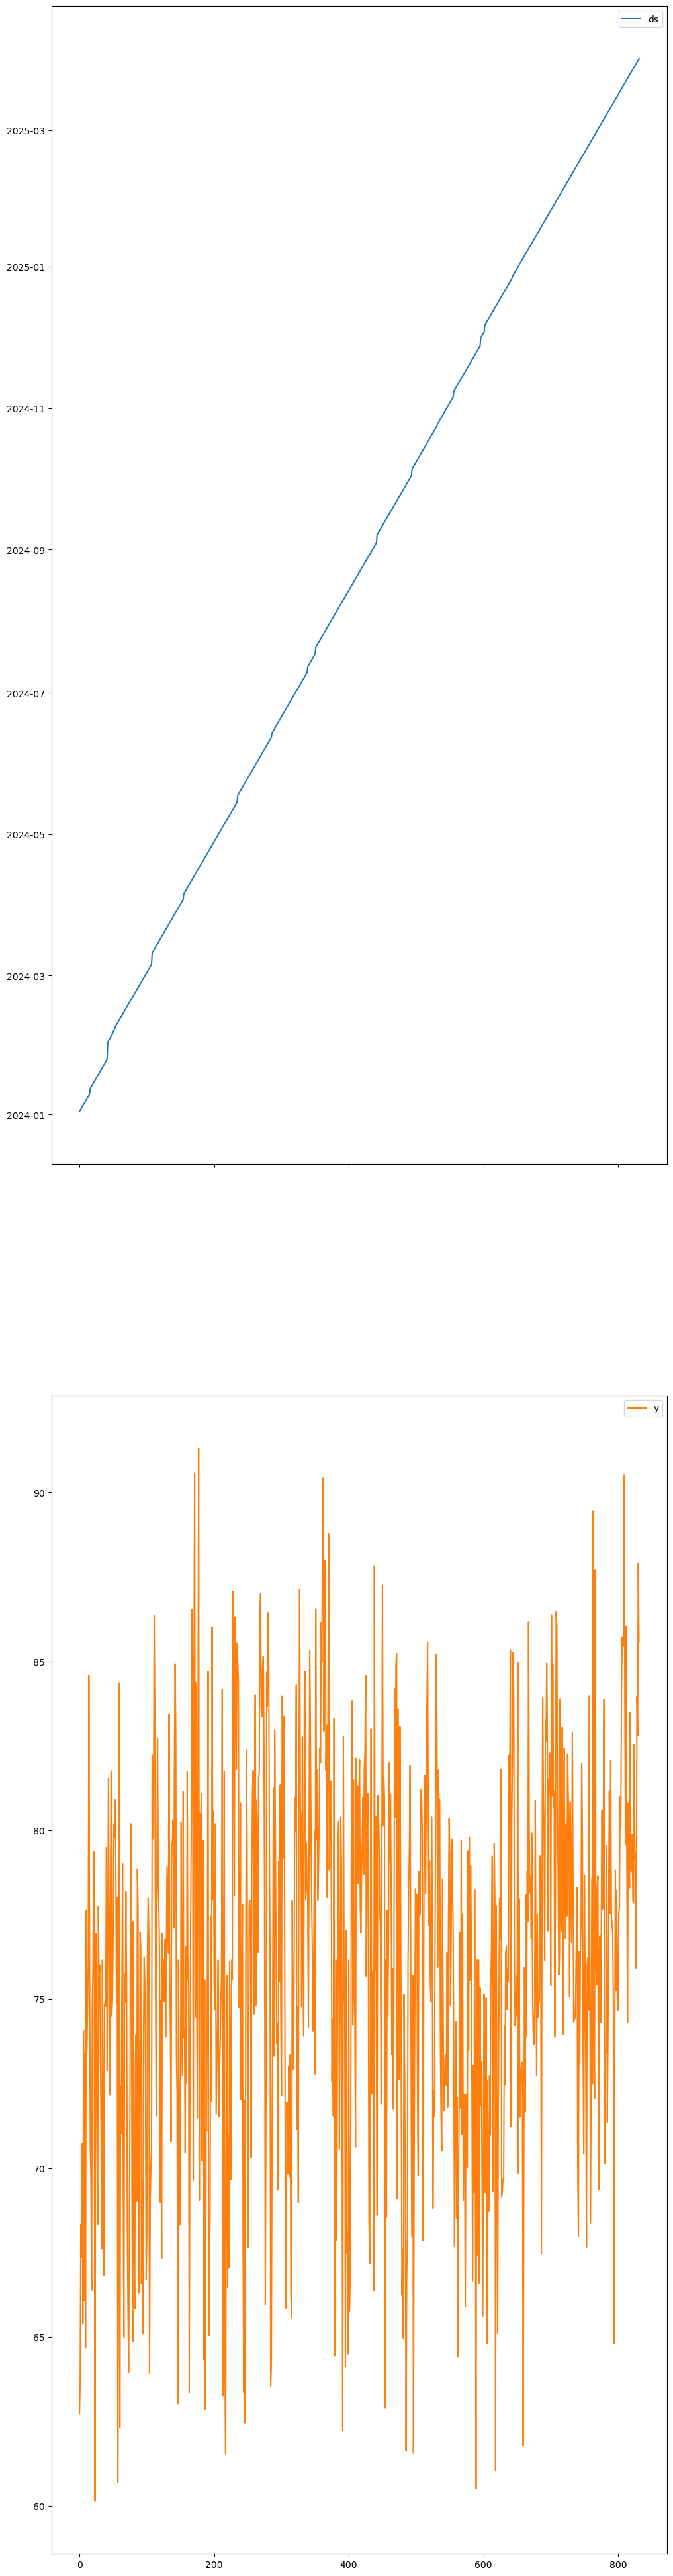

In [21]:
import seaborn as sns

# Graficamos nuestros datos
cols = df_prophet.columns

N = df_prophet.shape[0]
plots = df_prophet[cols][0:N]
plots.index = df_prophet.index[0:N]
_ = plots.plot(subplots=True, figsize =(12,50))

In [23]:
print("Valores faltantes:", df_prophet['y'].isnull().sum())
print("Valores infinitos:", np.isinf(df_prophet['y']).sum())

Valores faltantes: 0
Valores infinitos: 0


In [25]:
df_prophet = df_prop[['ds', 'y']].copy()

In [27]:
df_prophet

,ds,y
0,2024-01-02 08:00:00,62.742370
1,2024-01-02 20:00:00,63.721450
2,2024-01-03 08:00:00,68.335607
3,2024-01-03 20:00:00,67.360786
4,2024-01-04 08:00:00,70.736983
...,...,...
827,2025-03-29 20:00:00,75.920493
828,2025-03-30 08:00:00,83.961391
829,2025-03-30 20:00:00,82.811343
830,2025-03-31 08:00:00,87.899513


In [29]:
from prophet import Prophet

# Paso 1: dividir 80% train, 20% test
n_total = len(df_prophet)
n_train = int(n_total * 0.8)
n_test = n_total - n_train

df_train = df_prophet.iloc[:n_train]
df_test = df_prophet.iloc[n_train:]

17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing


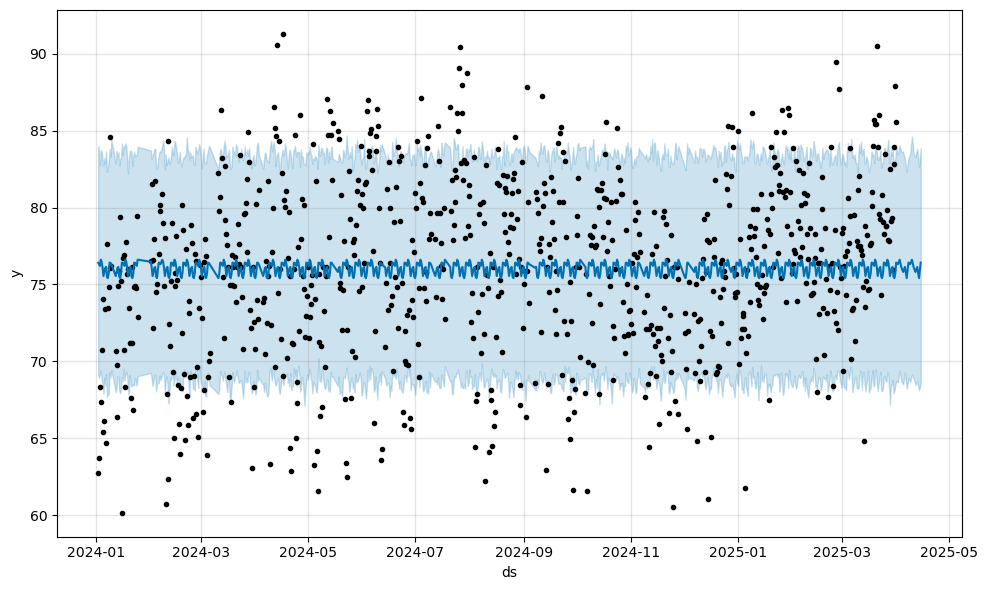

                     ds      trend  yhat_lower  yhat_upper  trend_lower  \
0   2024-01-02 08:00:00  76.043474   69.161976   83.995260    76.043474   
1   2024-01-02 20:00:00  76.043474   68.907213   83.712401    76.043474   
2   2024-01-03 08:00:00  76.043474   69.192128   82.754781    76.043474   
3   2024-01-03 20:00:00  76.043474   69.393932   83.760921    76.043474   
4   2024-01-04 08:00:00  76.043474   68.795357   83.592051    76.043474   
..                  ...        ...         ...         ...          ...   
841 2025-04-10 20:00:00  76.043474   68.887255   83.494265    76.043474   
842 2025-04-11 20:00:00  76.043474   68.461145   83.298233    76.043474   
843 2025-04-12 20:00:00  76.043474   68.700183   83.846529    76.043474   
844 2025-04-13 20:00:00  76.043474   68.112791   82.662547    76.043474   
845 2025-04-14 20:00:00  76.043474   68.505753   83.873110    76.043474   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      76.043474   

In [31]:
from prophet import Prophet

# 3. Entrenar modelo
model = Prophet(growth='flat', yearly_seasonality=False, weekly_seasonality=True)
model.fit(df_prophet)

# 4. Predecir
future = model.make_future_dataframe(periods=14)
forecast = model.predict(future)

# 5. Visualizar
model.plot(forecast)
plt.show()

print(forecast)